Pole Position: Predicting Final Position using Grid Position in Formula 1: A Bayesian Inference Application on discrete variables. 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

results = pd.read_csv('results.csv', encoding="utf-8")

results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [3]:
# this is to analyze how grid position influences final position
grid_cols = ['raceId', 'driverId', 'constructorId', 'grid', 'position']

grid_final = results[grid_cols]
grid_final.head()

,raceId,driverId,constructorId,grid,position
0,18,1,1,1,1
1,18,2,2,5,2
2,18,3,3,7,3
3,18,4,4,11,4
4,18,5,1,3,5


In [4]:
grid_final = grid_final.copy() # create a copy to avoid changing the original

# remove null values
grid_final.replace('\\N', np.nan, inplace=True)
grid_final.dropna(inplace=True)
#grid_final.head()

In [5]:
# Filter out rows where 'grid' or 'position' is zero
# Either cause driver didn't participate or finish the race
grid = grid_final[(grid_final['grid'] != 0) & (grid_final['position'] != 0)]

In [6]:
grid = grid.copy()

In [7]:
# change any float objects to integer
print(grid['grid'].dtype)
grid['grid'] = grid['grid'].astype(int)
print(grid['grid'].dtype)

int64
int64


In [8]:
print(grid['position'].dtype)
grid['position'] = grid['position'].astype(int)
print(grid['position'].dtype)

object
int64


In [9]:
# Filter the dataset for pole positions (grid position 1)
pole_positions = grid[grid['grid'] == 1]

# Count the number of times the pole position resulted in a win (positionOrder 1)
pole_wins = pole_positions[pole_positions['position'] == 1].shape[0]

# Print out the number of pole position wins
print(f"Number of wins from pole position: {pole_wins}")


Number of wins from pole position: 468


In [10]:
# Calculate the total number of races that had a pole position (for normalization)
total_pole_positions = pole_positions.shape[0]

# Calculate the percentage of races won from pole position
percentage_pole_wins = (pole_wins / total_pole_positions) * 100

# Print out the percentage of races won from pole position
print(f"Percentage of races won from pole position: {percentage_pole_wins:.2f}%")


Percentage of races won from pole position: 55.32%


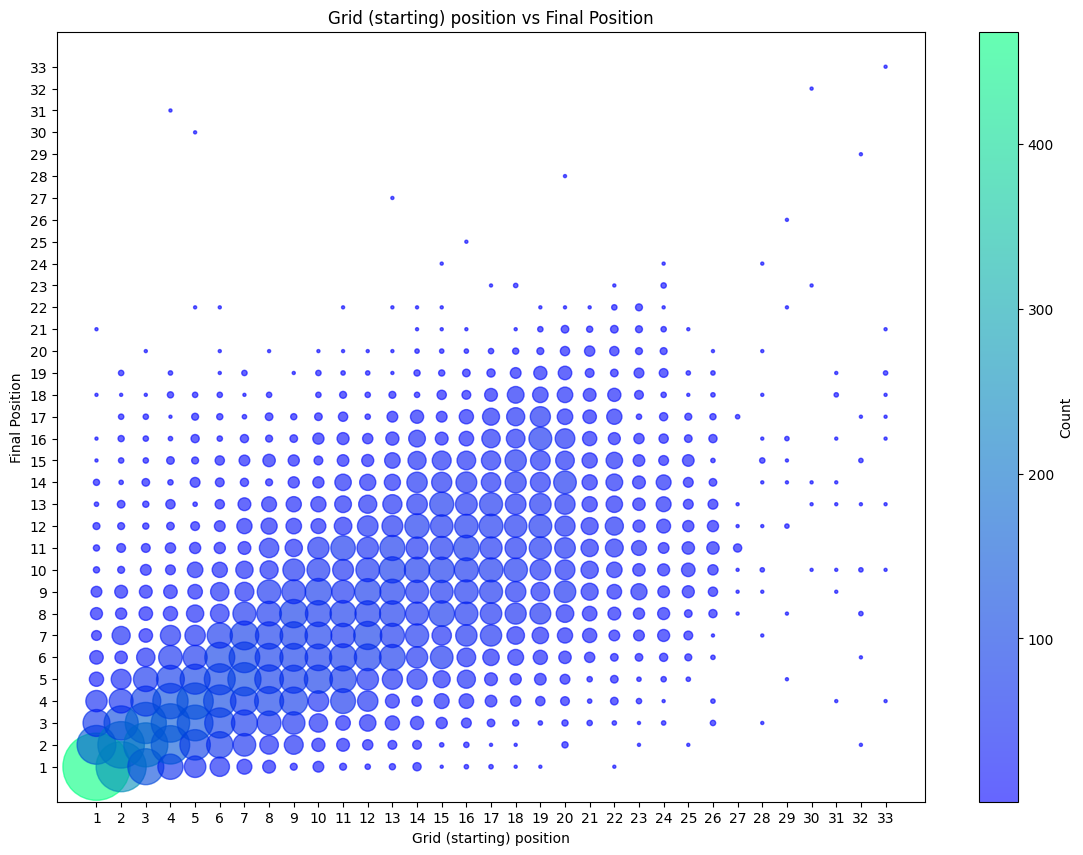

In [11]:
# Visualize
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Counting occurrences of each pair
df = pd.DataFrame({'X': grid['grid'], 'y': grid['position']})
counts = df.groupby(['X', 'y']).size().reset_index(name = 'counts')

# Plotting
size_scale = 5  # Adjust the size scale for visibility
norm = Normalize(vmin = counts['counts'].min(), vmax = counts['counts'].max())

plt.figure(figsize=(14, 10))
scatter = plt.scatter(counts['X'], counts['y'], s = counts['counts'] * size_scale, 
                    c = counts['counts'], cmap = 'winter', norm = norm, alpha = 0.6)

# Create colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Count')

# Discrete axis with integers
plt.xticks(np.arange(min(counts['X']), max(counts['X'])+1, 1))
plt.yticks(np.arange(min(counts['y']), max(counts['y'])+1, 1))
plt.xlabel('Grid (starting) position')
plt.ylabel('Final Position')
plt.title('Grid (starting) position vs Final Position')
plt.show()


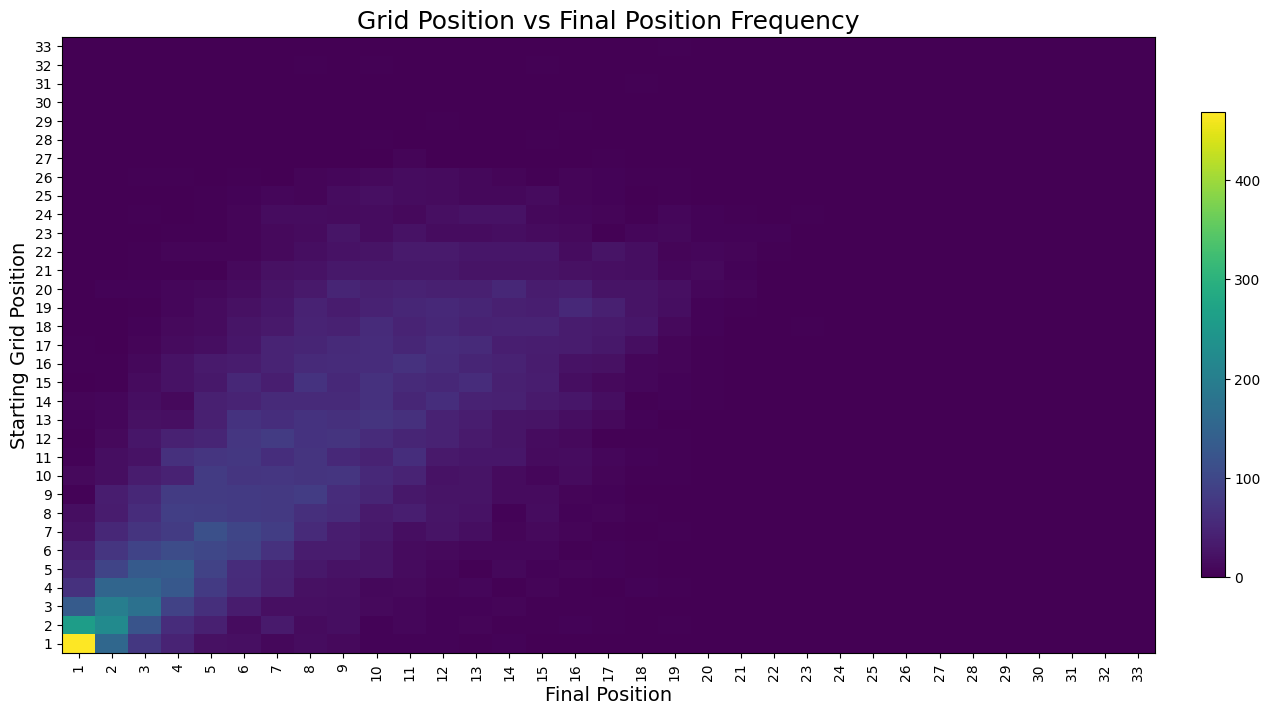

In [23]:
grid_positions = grid['grid'] # Grid positions 
final_positions = grid['position']  # Final positions 
data = {'grid': grid_positions, 'final_position': final_positions}
grid_df = pd.DataFrame(data)

# Creating a pivot table to count occurrences for the heatmap
pivot_table = grid_df.pivot_table(index='grid', columns='final_position', aggfunc='size', fill_value=0)

# Plotting the heatmap using imshow
plt.figure(figsize=(15, 8))
plt.title('Grid Position vs Final Position Frequency', fontsize = 18)
plt.xlabel('Final Position', fontsize = 14)
plt.ylabel('Starting Grid Position', fontsize = 14)
heatmap = plt.imshow(pivot_table.iloc[::-1], cmap='viridis', aspect='auto')  # Reversing the row order

# Adding a color bar to the side of the heatmap
plt.colorbar(heatmap, fraction=0.02, pad=0.04)

# Adjusting the ticks to show grid and final position numbers
plt.xticks(range(pivot_table.shape[1]), pivot_table.columns, rotation=90)
plt.yticks(range(pivot_table.shape[0]), pivot_table.index[::-1])  # Reversing the y-ticks as well

# Show the plot
plt.show()


In [ ]:
import pymc as pm
import arviz as az
import scipy.stats as sts
import pytensor.tensor as pt

In [39]:
counts = pivot_table.values
counts
N_start_positions = counts.shape[0]
N_start_positions

33

In [42]:
import pymc as pm
import numpy as np

# Assuming 'counts' is the numpy array you've provided
N_start_positions, N_final_positions = counts.shape

with pm.Model() as model:
    # Hyperpriors for the mean and standard deviation of the Poisson rates
    mu_hyper = pm.Exponential('mu_hyper', 1.0 / counts.mean())
    sigma_hyper = pm.Exponential('sigma_hyper', 1.0)
    
    # Priors for the Poisson rates for each starting position
    theta = pm.Gamma('theta', alpha=mu_hyper, beta=sigma_hyper, shape=(N_start_positions, N_final_positions))
    
    # Observations: Multinomial distribution for counts at each starting position
    observed_counts = pm.Multinomial('observed_counts', n=counts.sum(axis=1), p=theta / theta.sum(axis=1, keepdims=True), observed=counts)

    # Sample from the posterior
    trace = pm.sample(1000, tune=2000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_hyper, sigma_hyper, theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 317 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
az.plot_rank(trace, var_names=['mu_hyper', 'sigma_hyper', 'theta'])
az.plot_trace(trace, var_names=['mu_hyper', 'sigma_hyper', 'theta'])
az.summary(trace, var_names=['mu_hyper', 'sigma_hyper', 'theta'])

## Bayesian Inference on Grid vs Final position

In [13]:
import pymc as pm
import arviz as az
import scipy.stats as sts
import pytensor.tensor as pt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [14]:
# Linear Model with Student T likelihood
with pm.Model() as linear_model:
    # Priors
    a = pm.Uniform('a', lower = 0, upper = 100)
    b = pm.Normal('b', mu = 0, sigma = 10)
    nu = pm.HalfNormal('nu', sigma = 30)  # degrees of freedom for Student's T
    sigma = pm.Uniform('sigma', 0, 30)
    
    # Data
    x = pm.MutableData('x', grid['grid'])
    y = pm.MutableData('y', grid['position'])

    # Regression Mean (Linear Function)
    mu = pm.Deterministic('mu', a + b * x)
    
    # Likelihood using Student's T
    pm.StudentT('likelihood', nu = nu, mu = mu, sigma = sigma, observed = y)
    
    # Sampling
    linear_trace = pm.sample(tune = 1000, draws = 1000, chains = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, nu, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.384,0.059,2.277,2.497,0.002,0.001,1508.0,1672.0,1.00
b,0.488,0.005,0.479,0.496,0.000,0.000,1607.0,2023.0,1.01
nu,9.350,0.734,8.020,10.770,0.018,0.013,1617.0,2019.0,1.00
sigma,3.242,0.033,3.180,3.305,0.001,0.001,1663.0,2006.0,1.00


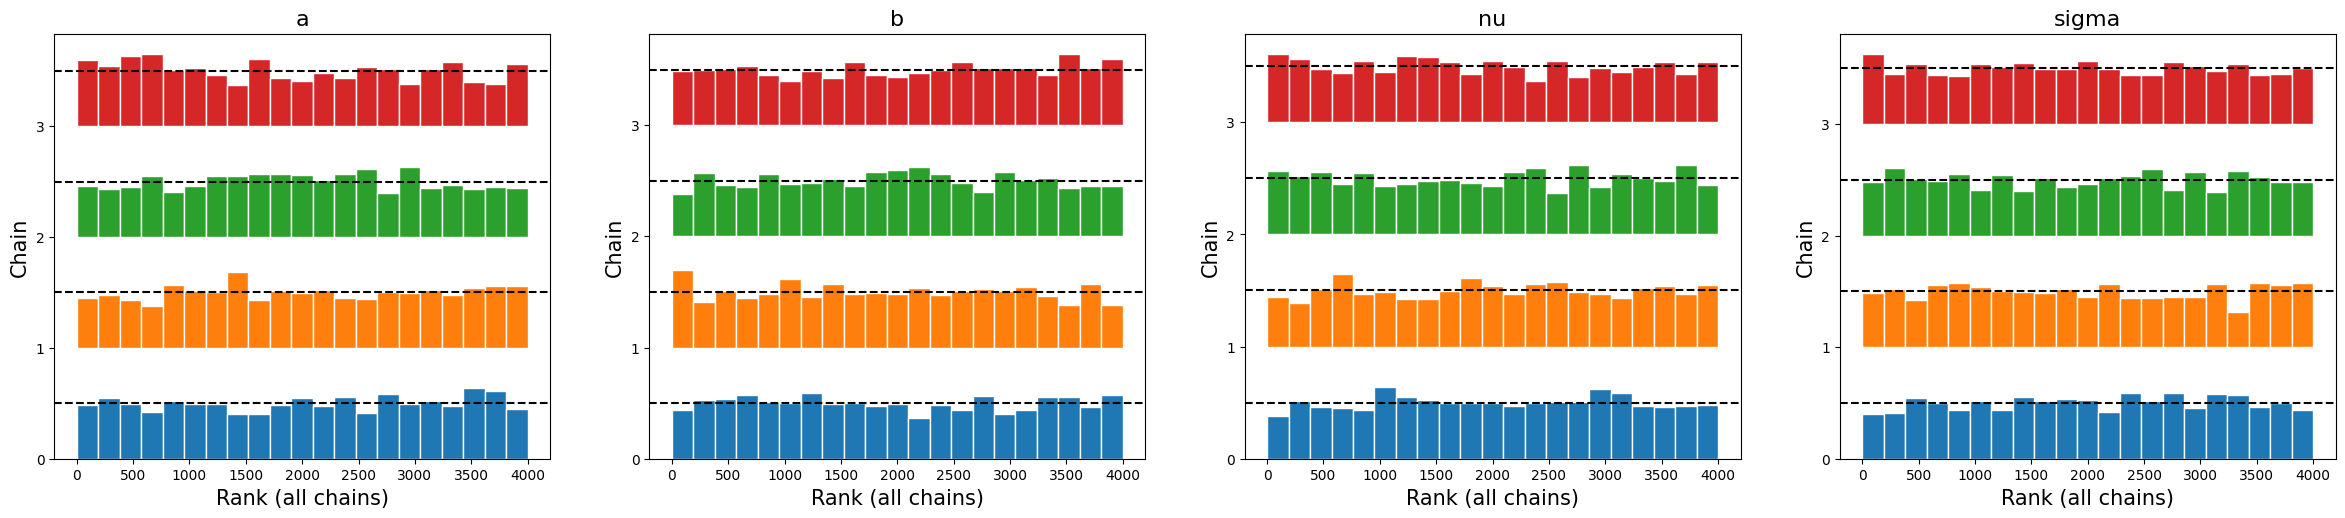

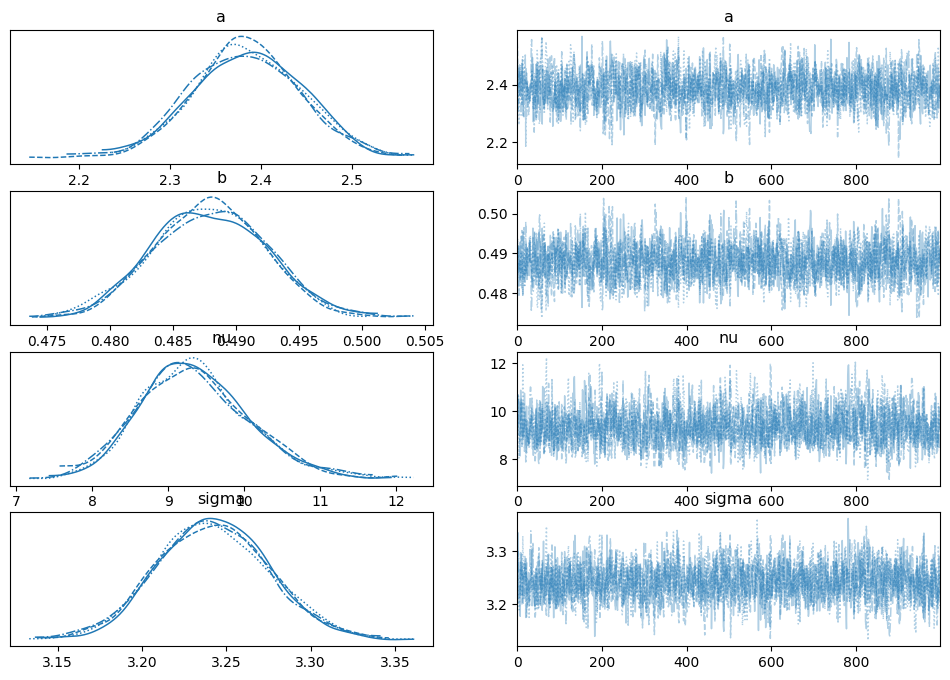

In [15]:
az.plot_rank(linear_trace, var_names=['a', 'b', 'nu', 'sigma'])
az.plot_trace(linear_trace, var_names=['a', 'b', 'nu', 'sigma'])
az.summary(linear_trace, var_names=['a', 'b', 'nu', 'sigma'])

/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


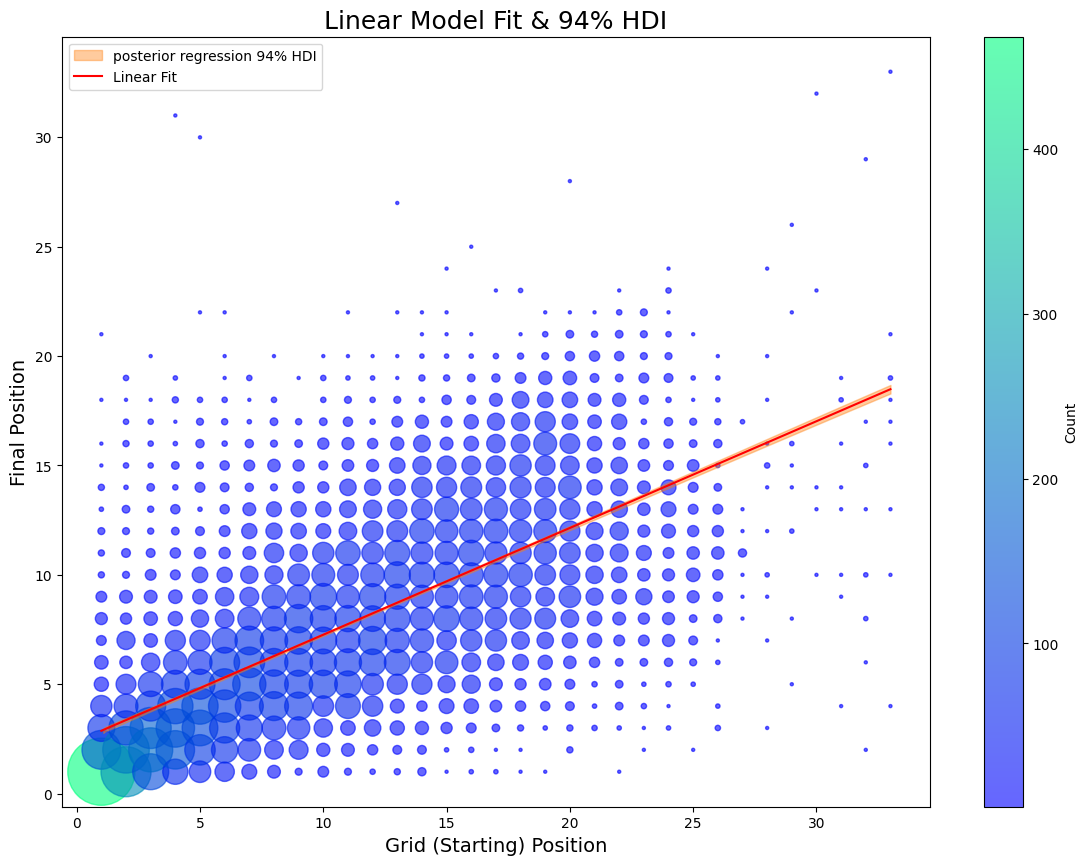

In [22]:
# Compute mean values for a and b
a_samples = linear_trace.posterior['a'].values.flatten()
b_samples = linear_trace.posterior['b'].values.flatten()

a_mean = a_samples.mean()
b_mean = b_samples.mean()

# Predicted values using the mean parameter estimates
x_vals = np.linspace(min(grid['grid']), 
                     max(grid['grid']), 1000)
y_vals = a_mean + b_mean * x_vals

# Compute posterior distributions of the predictions
posterior_mu = (a_samples[:, None] + b_samples[:, None] * x_vals)

# Plot the data with the line of best fit & HDI
plt.figure(figsize = (14, 10))
size_scale = 5  # Adjust the size scale for visibility
norm = Normalize(vmin = counts['counts'].min(), vmax = counts['counts'].max())


scatter = plt.scatter(counts['X'], counts['y'], s = counts['counts'] * size_scale, 
                    c = counts['counts'], cmap = 'winter', norm = norm, alpha = 0.6)
# Create colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Count')

az.plot_hdi(x_vals, posterior_mu, hdi_prob = 0.94, color = 'C1', 
            fill_kwargs = {'alpha': 0.4, 'label': 'posterior regression 94% HDI'})
plt.plot(x_vals, y_vals, c = 'red', label = 'Linear Fit') # the line
plt.title('Linear Model Fit & 94% HDI', fontsize=18)
plt.xlabel('Grid (Starting) Position', fontsize=14)
plt.ylabel('Final Position', fontsize=14)
plt.legend()
plt.show()

## Linear Regression Using sklearn

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'my_data' is your DataFrame with 'GridPosition' and 'FinalPosition'
X = grid[['grid']] # Predictor
y = grid['position']  # Response

# Creating a linear regression model
model = LogisticRegression()
model.fit(X, y)

# Making predictions
grid['predicted_final_pos'] = np.exp(model.predict(X))

grid.head()

/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,raceId,driverId,constructorId,grid,position,predicted_final_pos
0,18,1,1,1,1,2.718282
1,18,2,2,5,2,7.389056
2,18,3,3,7,3,54.598150
3,18,4,4,11,4,403.428793
4,18,5,1,3,5,7.389056


In [18]:
from scipy import stats

x = grid['grid'] # Predictor
y = grid['position']  # Response

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# Print the results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")

# To predict a new set of y values using the regression line
predicted_y = [slope * xi + intercept for xi in x]



Slope: 0.46654472242462663
Intercept: 2.7970136927556695
R-squared: 0.4236341408167415
P-value: 0.0
Standard error: 0.004407985902694191


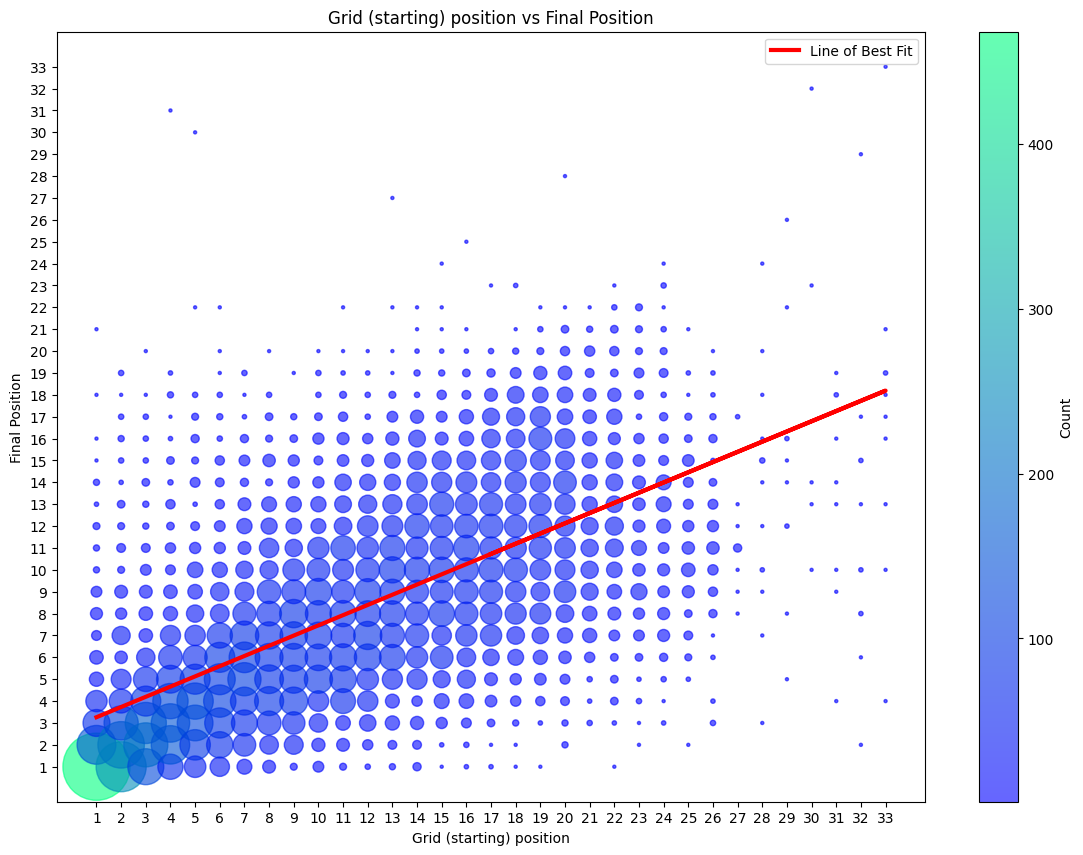

In [19]:
# Generate predicted y-values for each x-value using the slope and intercept
predicted_y = intercept + slope * x

plt.figure(figsize=(14, 10))
scatter = plt.scatter(counts['X'], counts['y'], s = counts['counts'] * size_scale, 
                    c = counts['counts'], cmap = 'winter', norm = norm, alpha = 0.6)

# Plot the line of best fit
plt.plot(x, predicted_y, color='red', label='Line of Best Fit', linewidth = 3)

# Create colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Count')

# Discrete axis with integers
plt.xticks(np.arange(min(counts['X']), max(counts['X'])+1, 1))
plt.yticks(np.arange(min(counts['y']), max(counts['y'])+1, 1))
plt.xlabel('Grid (starting) position')
plt.ylabel('Final Position')
plt.title('Grid (starting) position vs Final Position')
plt.legend()
plt.show()


In [20]:
whole = round(predicted_y, 0)
whole[0:10]

0      3.0
1      5.0
2      6.0
3      8.0
4      4.0
5      9.0
6     11.0
7     10.0
22     4.0
23     5.0
Name: grid, dtype: float64